In [302]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re

In [303]:
arg_component_balance=True
arg_add_new_dataset=False
arg_add_transformer=True

In [304]:
result_path = '/data/coding/chaochuan/TSGym/meta/results'
datasets = ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2', 'ili', 'weather', 'ECL', 'Exchange', 'traffic']
if arg_add_new_dataset:
    datasets.extend(['covid-19', 'fred-md'])
file_list = [f'{dataset}-component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}.npz' for dataset in datasets]

baselines = ['iTransformer',
 'MambaSimple',
 'PatchTST',
 'TimeMixer',
 'Koopa',
 'SegRNN',
 'DLinear',
 'FEDformer',
 'Crossformer',
 'Informer',
 'PAttn',
 'ETSformer',
 'TimeXer',
 'LightTS',
 'Nonstationary',
 'TiDE',
 'Pyraformer',
 'MICN',
 'Transformer',
 'FiLM',
 'TimesNet',
 'TSMixer',
 'Autoformer',
 'Reformer']
print(len(file_list))

9


In [305]:
# sota performance
def search_sota_performance(dataset, pred_lens=[96], path = '/data/coding/chaochuan/TSGym/results'):
    result_dict = {}
    for pred_len in pred_lens:
        model_list = os.listdir(path)
        model_list = [_ for _ in model_list if f'pl{pred_len}' in _ and dataset in _]
        result_dict[pred_len] = {}
        for model in model_list:
            result = np.load(os.path.join(path, model, 'metrics.npy'), allow_pickle=True)
            result_dict[pred_len][model] = result[1]

    df = pd.DataFrame.from_dict(result_dict[pred_lens[0]], orient='index')
    df.columns = ['mse']
    df = df.sort_values(by='mse')
    df.index = [_.split('_')[6] for _ in df.index]

    return df

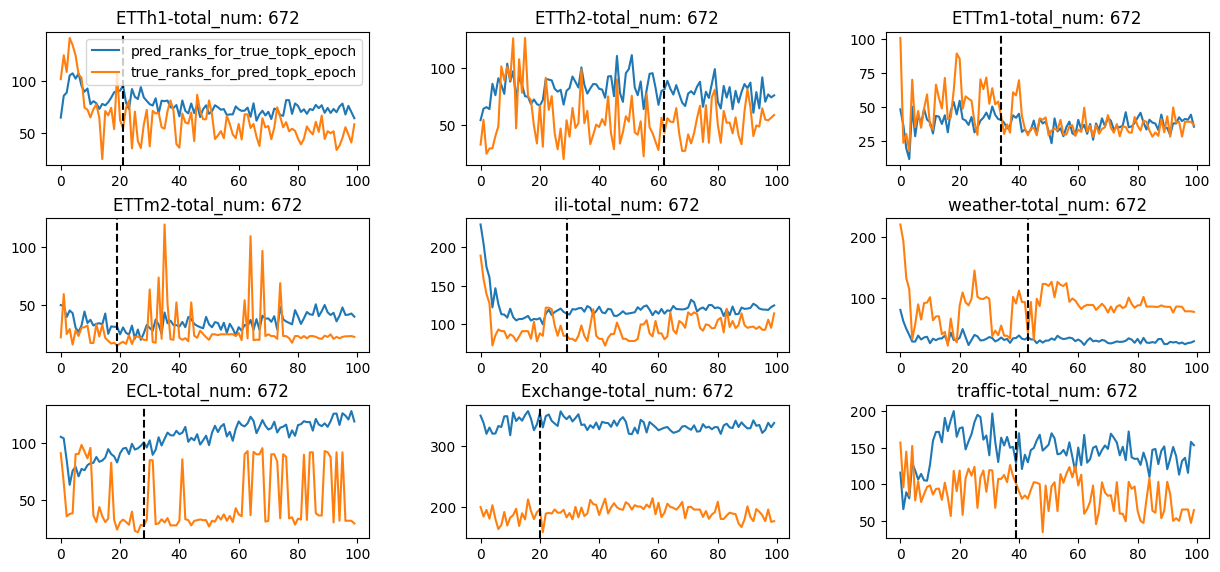

In [306]:
fig = plt.figure(figsize=(15, 9))
for i, file in enumerate(file_list):
    try:
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        # print(perf_epoch.files)

        fig.add_subplot(4, 3, i+1)
        for _ in perf_epoch.files:
            if _ in ['pred_ranks_for_true_topk_epoch', 'true_ranks_for_pred_topk_epoch']:
                plt.plot(perf_epoch[_], label=_)
            elif _ == 'total_num':
                plt.title(f'{file.replace(".npz", "").split("-")[0]}-total_num: {perf_epoch[_]}')
            elif _ == 'best_epoch':
                plt.axvline(perf_epoch['best_epoch'].item(), color='black', linestyle='--')
            else:
                pass 

        if i==0: plt.legend()
    except:
        continue

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

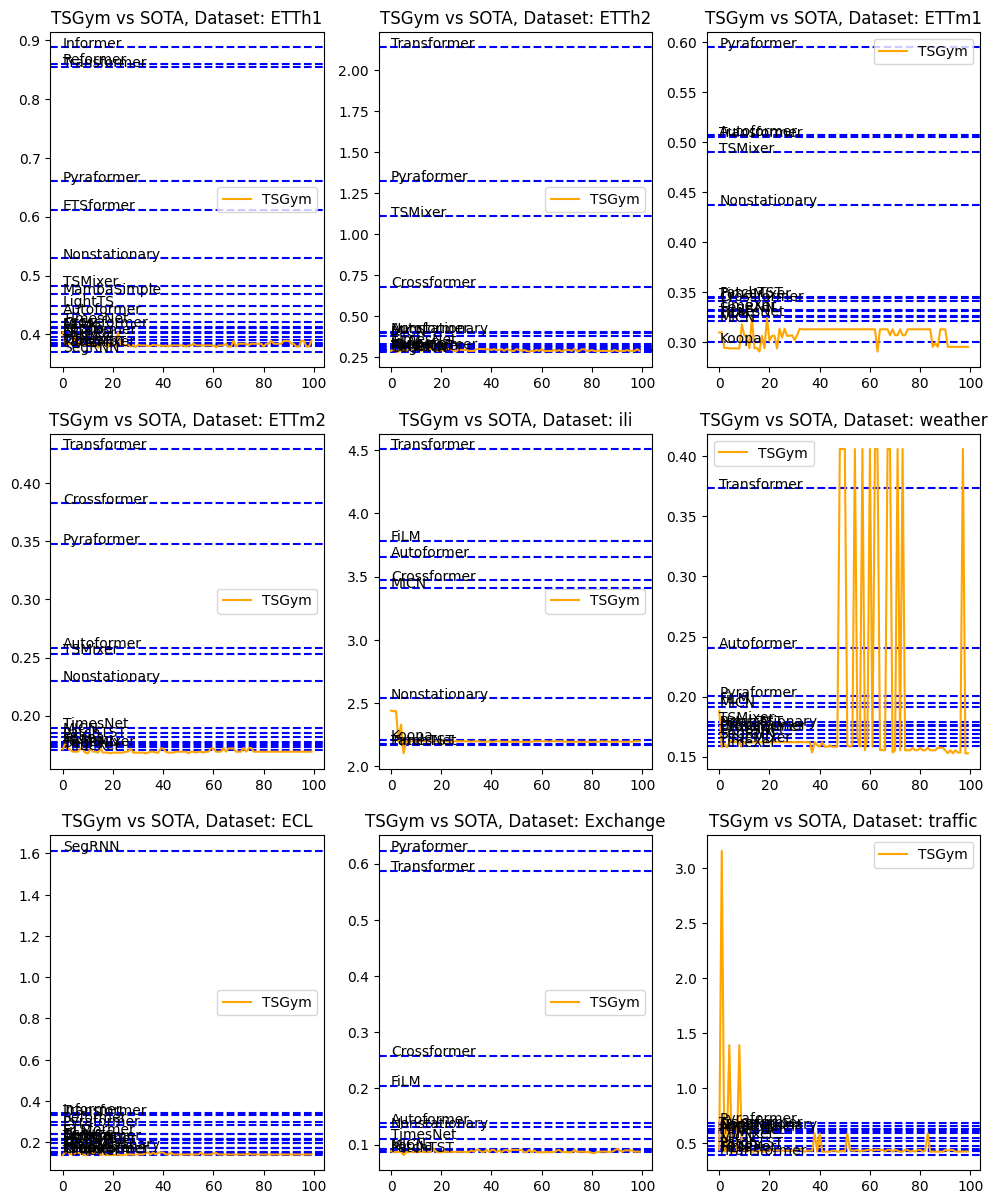

In [307]:
fig = plt.figure(figsize=(12, 20))
for i, file in enumerate(file_list):
    try:
        dataset = file[:re.search('-component', file).start()]
        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[24])
        else:
            df = search_sota_performance(dataset)
        # except:
        #     continue
        fig.add_subplot(4, 3, i+1)
        for model, metric in df.iterrows():
            plt.axhline(y=metric.item(), color='blue', linestyle='--')
            plt.text(0, metric.item(), model, color='black')

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']
        plt.plot(top1_perf_epoch, color='orange', label='TSGym')

        plt.legend()
        plt.title(f'TSGym vs SOTA, Dataset: {dataset}')
    except:
        continue

plt.show()

In [308]:
# TSGym vs best sota
dfs = []
ranks = {k: [] for k in baselines}
ranks['TSGym'] = []
for i, file in enumerate(file_list):
    # dataset = file.split('-')[0]
    dataset = file[:re.search('-component', file).start()]

    if dataset in ['ili', 'covid-19', 'fred-md']:
        df = search_sota_performance(dataset, pred_lens=[24])
    else:
        df = search_sota_performance(dataset)


    # 添加图例和标题
    perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
    top1_perf_epoch = perf_epoch['top1_perf_epoch']



    df.loc['TSGym'] = top1_perf_epoch[perf_epoch['best_epoch'].item()]
    df = df.sort_values(by='mse')
    df = df.reset_index()
    df.columns = ['model', dataset]
    # df = df.iloc[:10, :]
    for baseline in baselines:
        if len(np.where(df['model'] == baseline)[0]) > 0:
            ranks[baseline].append((np.where(df['model'] == baseline)[0] + 1).item())
    ranks['TSGym'].append((np.where(df['model'] == 'TSGym')[0] + 1).item())
    dfs.append(df)

dfs = pd.concat(dfs, axis=1)
dfs

,model,ETTh1,model,ETTh2,model,ETTm1,model,ETTm2,model,ili,model,weather,model,ECL,model,Exchange,model,traffic
0,SegRNN,0.370867,SegRNN,0.282564,Koopa,0.299445,TSGym,0.167466,PatchTST,2.168191,TSGym,0.158244,TSGym,0.139320,TSGym,0.086593,iTransformer,0.392156
1,TSGym,0.378182,TSGym,0.286459,TSGym,0.312595,TimeXer,0.170625,TimesNet,2.174988,TimeXer,0.158659,TimeXer,0.140439,PatchTST,0.086641,TSGym,0.422930
2,PatchTST,0.380158,TimeXer,0.287365,MICN,0.320593,SegRNN,0.172851,TSGym,2.198923,TimeMixer,0.162554,iTransformer,0.147862,Koopa,0.091252,FiLM,0.426619
3,TimeMixer,0.381575,TimeMixer,0.291129,FiLM,0.324987,TimeMixer,0.174330,Koopa,2.209361,SegRNN,0.165622,Crossformer,0.148745,MICN,0.092951,TimeXer,0.433298
4,TimeXer,0.383762,PatchTST,0.295004,TimesNet,0.325995,FiLM,0.176033,Nonstationary,2.537160,TimesNet,0.169092,Koopa,0.152825,TimesNet,0.109883,Koopa,0.446586
5,TiDE,0.384989,iTransformer,0.300953,SegRNN,0.330613,Koopa,0.177155,MICN,3.408669,Crossformer,0.171791,TimeMixer,0.154134,Nonstationary,0.130638,PatchTST,0.471588
6,PAttn,0.391195,Koopa,0.308469,TimeXer,0.331773,PatchTST,0.181935,Crossformer,3.470287,iTransformer,0.172495,Nonstationary,0.169613,Autoformer,0.137937,MICN,0.516740
7,DLinear,0.395788,FiLM,0.316959,Crossformer,0.340736,MICN,0.185391,Autoformer,3.657251,PatchTST,0.175675,MICN,0.170311,FiLM,0.204847,TSMixer,0.547612
8,FEDformer,0.401848,TimesNet,0.328028,TimeMixer,0.344005,TimesNet,0.189387,FiLM,3.782863,Nonstationary,0.175962,TimesNet,0.172471,Crossformer,0.257572,TimesNet,0.589141
9,Koopa,0.403704,MICN,0.379799,PatchTST,0.345098,Nonstationary,0.230007,Transformer,4.507895,TSMixer,0.178758,PatchTST,0.196937,Transformer,0.587760,Autoformer,0.613174


In [309]:
ranks

{'iTransformer': [6, 7, 3, 1],
 'MambaSimple': [17],
 'PatchTST': [3, 5, 10, 7, 1, 8, 10, 2, 6],
 'TimeMixer': [4, 4, 9, 4, 3, 6],
 'Koopa': [10, 7, 1, 6, 4, 5, 3, 5],
 'SegRNN': [1, 1, 6, 3, 4, 22, 12],
 'DLinear': [8, 12],
 'FEDformer': [9, 11],
 'Crossformer': [13, 13, 8, 14, 7, 6, 4, 9],
 'Informer': [24, 21],
 'PAttn': [7],
 'ETSformer': [20, 17],
 'TimeXer': [5, 3, 7, 2, 2, 2, 4],
 'LightTS': [16, 15],
 'Nonstationary': [19, 12, 11, 10, 5, 9, 7, 6, 11],
 'TiDE': [6],
 'Pyraformer': [21, 15, 15, 13, 13, 18, 11, 14],
 'MICN': [12, 10, 3, 8, 6, 11, 8, 4, 7],
 'Transformer': [22, 16, 13, 15, 10, 15, 20, 10, 13],
 'FiLM': [11, 8, 4, 5, 9, 12, 16, 8, 3],
 'TimesNet': [14, 9, 5, 9, 2, 5, 9, 5, 9],
 'TSMixer': [18, 14, 12, 11, 10, 14, 8],
 'Autoformer': [15, 11, 14, 12, 8, 14, 13, 7, 10],
 'Reformer': [23, 19],
 'TSGym': [2, 2, 2, 1, 3, 1, 1, 1, 2]}

In [310]:
{k: np.mean(v) for k,v in ranks.items() if len(v) > 0}

{'iTransformer': 4.25,
 'MambaSimple': 17.0,
 'PatchTST': 5.777777777777778,
 'TimeMixer': 5.0,
 'Koopa': 5.125,
 'SegRNN': 7.0,
 'DLinear': 10.0,
 'FEDformer': 10.0,
 'Crossformer': 9.25,
 'Informer': 22.5,
 'PAttn': 7.0,
 'ETSformer': 18.5,
 'TimeXer': 3.5714285714285716,
 'LightTS': 15.5,
 'Nonstationary': 10.0,
 'TiDE': 6.0,
 'Pyraformer': 15.0,
 'MICN': 7.666666666666667,
 'Transformer': 14.88888888888889,
 'FiLM': 8.444444444444445,
 'TimesNet': 7.444444444444445,
 'TSMixer': 12.428571428571429,
 'Autoformer': 11.555555555555555,
 'Reformer': 21.0,
 'TSGym': 1.6666666666666667}

In [318]:
{k: np.mean(v) for k,v in ranks.items() if len(v) == len(datasets)}

{'PatchTST': 5.777777777777778,
 'Nonstationary': 10.0,
 'MICN': 7.666666666666667,
 'Transformer': 14.88888888888889,
 'FiLM': 8.444444444444445,
 'TimesNet': 7.444444444444445,
 'Autoformer': 11.555555555555555,
 'TSGym': 1.6666666666666667}

In [312]:
dfs.to_excel(f'/data/coding/chaochuan/TSGym/meta/component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}.xlsx', index=False)


meta-feature的差异性

In [313]:
# meta_feature_path = '/data/coding/chaochuan/TSGym/meta_learner_cc/meta_feature_copy/meta_feature'

In [314]:
# meta_features_dict = {}
# for file in os.listdir(meta_feature_path):
#     if file.endswith('.npz'):
#         meta_feature = np.load(os.path.join(meta_feature_path, file), allow_pickle=True)
#         meta_features_dict[file.replace('.npz', '').replace('meta_feature_', '')] = meta_feature['meta_feature']

In [315]:
# meta_features = np.stack(list(meta_features_dict.values()))
# meta_features = np.clip(meta_features, -1e4, 1e4)

# # z-score
# mu = np.nanmean(meta_features, axis=0, keepdims=True)
# std = np.nanstd(meta_features, axis=0, keepdims=True)

# meta_features = (meta_features - mu) / (std + 1e-6)
# meta_features = np.nan_to_num(meta_features, nan=0.0)

In [316]:
# fig = plt.figure(figsize=(20, 20))

# for seed in range(1, 5):
#     tsne = TSNE(n_components=2, random_state=seed, perplexity=10)
#     meta_features_tsne = tsne.fit_transform(meta_features) 
#     meta_features_dict_tsne = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_tsne)}
#     fig.add_subplot(2, 2, seed)
#     for k, v in meta_features_dict_tsne.items():
#         plt.scatter(v[0], v[1])
#         plt.text(v[0], v[1], k, fontsize=12)
# fig.suptitle('TSNE', fontsize=16)
# plt.show()


In [317]:
# fig = plt.figure(figsize=(20, 20))

# pca = PCA(n_components=2, random_state=42)
# meta_features_pca = pca.fit_transform(meta_features) 
# meta_features_dict_pca = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_pca)}
# for k, v in meta_features_dict_pca.items():
#     plt.scatter(v[0], v[1])
#     plt.text(v[0], v[1], k, fontsize=16)
# plt.title('PCA', fontsize=16)
# plt.show()
